Related tweet:
    https://twitter.com/sassorgsa/status/1138767881192333313

# <div dir="rtl" lang="ar">مهمة</div>

<div dir="rtl" lang="ar">لنفرض ان لدينا بيانات عن جميع سكان مدينة الرياض كـ <b>العمر، الوزن، الطول، الراتب</b> (دعنا نسميها بالـ <b>خصائص</b> أو الأبعاد). ونرغب في تقسيم هذه البيانات إلى عدة مجموعات بحيث أن كل مجموعة ستحتوي على أشخاص متشابهين (أي يملكون خصائص مشابهة).</div>

<div dir="rtl" lang="ar"><b>كيف يمكننا القيام بذلك</b>؟</div>

<div dir="rtl" lang="ar"><b>الجواب</b>: يمكننا استخدام <b>خوارزمية التجميع</b></div>

# <div dir="rtl" lang="ar"> خوارزمية التجميع (أو التصنيف) k-means</div>
<br>
<div dir="rtl" lang="ar">
    تستخدم هذه الخوارزمية كثيراً في مجال <b>تعلم الآلة</b> و <b>علم البيانات</b> لتجميع "تقسيم" نقاط البيانات المتشابهه (المتقاربة) مع بعضها البعض في عدد معين من المجموعات.
</div>

## <div dir="rtl" lang="ar">تنويه</div>

<div dir="rtl" lang="ar">
في هذا الشرح، ولغرض تبسيط المفهوم:
</div>


<div dir="rtl" lang="ar">- سنستخدم عدد صغير من البيانات لشرح كيف تعمل الخوارزمية بالتفصيل.</div>
<div dir="rtl" lang="ar">- سنفترض بيانات وهمية لـ <b>الوزن</b> و <b>الطول</b> لعشرة اشخاص فقط. لاحظ <b>خاصيتين</b> فقط بمعنى كل نقطة في مدخلات البيانات ستحتوي على <b>بعدين</b>. عموماً، الخوارزمية تنطبق على أي عدد من الأبعاد.</div>
<div dir="rtl" lang="ar">- سنقوم بكتابة الخوارزمية من الصفر بدون إستخدام أي مكتبات برمجية جاهزة و حتى بدون إستخدام أي `import` من بايثون.</div>

> <div dir="rtl" lang="ar"> ملاحظة: يمكن للبيانات أن تكون عن أي شي معين و يمكن ان تحتوي على اكثر من بعد او خاصية، مثلاً: بيانات مرضى، أو قياسات درجات حرارة، أو أسعار اسهم، وغيرها
</div>

<hr>

<div dir="rtl" lang="ar">
دعنا أولاً نبداً بـ بيانات الطول و الوزن للعشرة أشخاص، كالتالي: 

</div>

In [1]:
weights = [74, 77, 81, 76, 80, 91, 88, 93, 88, 92]           # الوزن بالكيلوغرام
heights = [179, 182, 181, 175, 174, 182, 178, 178, 174, 173] # الطول بالسنتيمتر

<div dir="rtl" lang="ar">
<meta charset="utf-8">

لنصور البيانات بشكل افضل، سنتعرضها في الرسم البياني التالي:
  
</div>

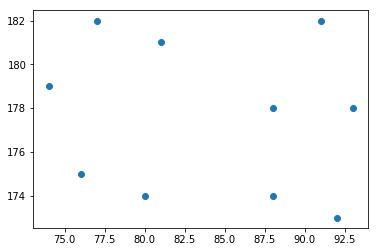

In [2]:
# أمر خاص بالنوتبوك لعرض الرسوم البيانية هنا مباشرة
%matplotlib inline
import matplotlib.pyplot as plt        # نستدعي مكتبة الرسوم البيانية
plt.scatter(weights, heights);         # نعطيها بيانات الطول و الوزن

<div dir="rtl" lang="ar">
<meta charset="utf-8">
من اجل تسهيل كتابة الكود، سنضع البيانات في متغير واحد. نسميه الأمثلة. كما يلي:

</div>

In [3]:
samples = [list(point) for point in zip(weights, heights)]
samples

[[74, 179],
 [77, 182],
 [81, 181],
 [76, 175],
 [80, 174],
 [91, 182],
 [88, 178],
 [93, 178],
 [88, 174],
 [92, 173]]

<div dir="rtl" lang="ar">
تحتاج خوارزمية التجميع أن تقوم بحساب المسافات بين النقاط، لذلك فيما يلي، سنكتب دالة لحساب المسافة بين نقطتين ما (وهي المسافة العادية، نفس المسافة الناتجة إذا ماستخدمنا المسطرة بين النقطتين). تسمى هذي المسافة بالمسافة الإقليدية، ويتم حسابها بين نقطين $U=(u_1, u_2, ...,u_n)$ و $V=(v1, v2, ..., v_n)$ بحيث ان $n$ هو عدد الأبعاد في كل نقطة كما يلي: 
</div>

$$
\sqrt{\left(u_{1}-v_{1}\right)^{2}+\left(u_{2}-v_{2}\right)^{2}+\cdots+\left(u_{n}-v_{n}\right)^{2}}=\sqrt{\sum_{i=1}^{n}\left(u_{i}-v_{i}\right)^{2}}
$$

<div dir="rtl" lang="ar">
فيما يلي دالة بايثون لحساب هذه المسافة:
</div>

In [4]:
def distance(u, v):
    """
    حساب المسافة الإقليدية بين نقطتين
    المسافة = square_root( (u0 - v0)^2 + (u1 - v1)^2) )
    
    u: [int, int], النقطة الأولى
    v: [int, int], النقطة الثانية
    """
    sum_ = sum( (u[i] - v[i])**2 for i in range(len(u)) ) # ناتج الجمع اللي تحت الجذر
    return sum_**(1/2)                                    # نأخذ الجذر للمجموع

<div dir="rtl" lang="ar">
سنكتب دالة تأخذ نقطة معينة (لنسميها النقطة الهدف) مع مجموعة نقاط أخرى (لنسميهم نقاط المنتصف)، وترجع النقطة (من نقاط المنتصف) الأقرب إلى النقطة الهدف. كما يلي:

</div>

In [5]:
def get_closer(target, *args):
    """
    حساب أي النقاط اقرب إلى النقطة الهدف
    
    target:  [int, int], النقطة الهدف
    *args: [[int, int]], مجموعة نقاط 
    """
    min_distance = float('inf')
    for point in args:
        d = distance(point, target)
        if d < min_distance:
            min_distance = d
            closer = point
    return closer

<div dir="rtl" lang="ar">
<meta charset="utf-8">
سنحتاج دالة أخرى تقوم بحساب نقطة المنتصف لمجموعة من النقاط، نستطيع كتابتها كما يلي:

</div>

In [6]:
def get_center(cluster):
    """
    حساب نقطة المنتصف لكل النقاط في المجموعة
    
    cluster: List[List[int, int]], قائمة من النقاط
    """
    n = max(len(cluster), 1) # تفادي القسمة على صفر بحالة القائمة لاتحتوي على أية نقاط
    center = [sum(p[0] for p in cluster) / n, sum(p[1] for p in cluster) / n]
    return center

<div dir="rtl" lang="ar">
الآن وبعد أن قمنا بكتابة كل الدوال البرمجية التي تحتاجها خوارزمية التجميع، نقوم بكتابة الخوارزمية كالآتي:
</div>

In [7]:
def k_means(data, k=2, *centers):
    """
    خوارزمية التجميع "التصنيف" مع تنفيذ تكراري
    
    data: List[List[int]], مجموعة النقاط البيانية التي نرغب في تصنيفها في مجموعات
    k: int, عدد المجموعات التي نرغب بتكوينها
    seeds: List[List[int]], مُدخل إختياري - نقاط المنتصف (المركزية) الإبتدائية لكل مجموعة
    """
    # نحدد نقاط المنتصف المبدئية إذا كانت لم تدخل مع البيانات
    # عشوائياً نختار من النقاط الأولى في البيانات (بعدد المجموعات)  كنقاط منتصف أولية
    centers = list(centers) if centers else [data[i] for i in range(k)]
        
    clusters = [[] for _ in range(k)] # ننشئ قوائم فارغة لحفظ النقاط التابعة لكل قائمة بها
    
    # نقوم بزيارة جميع النقاط البيانية 
    # ولكل نقطة، سنحسب المسافة بينها وبين نقاط المنتصف  
    for point in data:
        # حساب أي نقاط المنتصف أقرب إلى النقطة البيانية الحالية
        nearest = get_closer(point, *centers)
        # نسترجع عنوان أو دليل (من بين قائمة نقاط المنتصف) نقطة المنتصف الأقرب للنقطة الحالية
        nearest_cluster_index = centers.index(nearest) 
        # نضيف النقطة الحالية إلى قائمة المجموعة التي تتبع لها من بين مجموعة القوائم
        clusters[nearest_cluster_index].append(point)
    # نقاط المنتصف الجديدة
    updated_centers = [get_center(cluster) for cluster in clusters]

    # return when converge
    if centers == updated_centers: return clusters, centers

    # if not converge, recurse with new means as the seeds
    print(f"ITER:\n\tinit centroids: {centers}\n\tnew centroids: {updated_centers}")
    return k_means(data, k, *updated_centers)

In [8]:
# plot and print results
def report_result(clusters, centers):
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w'] # available colors in matplotlib
    n = len(clusters)
    colors = colors[:n]
    for i, clus, cent, col in zip(range(1, n+1), clusters, centers, colors):
        plt.scatter([c[0] for c in clus], [c[1] for c in clus], c=col, label=f"cluster {i}")
        plt.scatter(cent[0], cent[1], marker="x", label=f"centroid {i}")
        
    plt.grid();plt.legend(bbox_to_anchor = (1, 1));plt.show()

<div dir="rtl" lang="ar">
الآن سنقوم باختبار نتيجة الخوارزمية على أمثلة الطول والوزن لعشرة اشخاص:
</div>

ITER:
	init centroids: [[74, 179], [77, 182]]
	new centroids: [[76.66666666666667, 176.0], [87.14285714285714, 178.28571428571428]]
ITER:
	init centroids: [[76.66666666666667, 176.0], [87.14285714285714, 178.28571428571428]]
	new centroids: [[77.6, 178.2], [90.4, 177.0]]


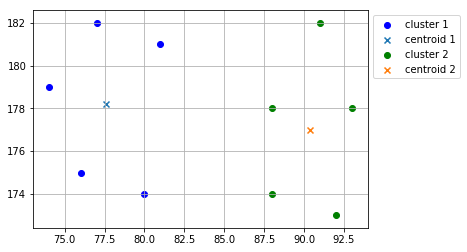

In [9]:
clusters, centers = k_means(samples, k=2)
report_result(clusters, centers)

<div dir="rtl" lang="ar">
اخيراً، سنختبر الخوارزمية لتصنف البيانات في ثلاث مجموعات بدل المجموعتين:
</div>

ITER:
	init centroids: [[74, 179], [77, 182], [81, 181]]
	new centroids: [[75.0, 177.0], [77.0, 182.0], [87.57142857142857, 177.14285714285714]]
ITER:
	init centroids: [[75.0, 177.0], [77.0, 182.0], [87.57142857142857, 177.14285714285714]]
	new centroids: [[76.66666666666667, 176.0], [79.0, 181.5], [90.4, 177.0]]


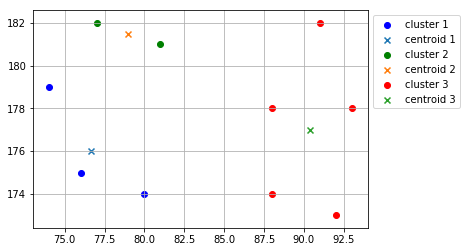

In [10]:
clusters, centers = k_means(samples, k=3)
report_result(clusters, centers)

<div dir="rtl" lang="ar">
مثال اخر على بيانات أخرى:
</div>

In [11]:
from random import randint

In [12]:
def random_point(dimension=2):
    return [randint(40, 100) for _ in range(dimension)]

In [13]:
samples = [random_point() for _ in range(100)]

ITER:
	init centroids: [[51, 53], [65, 77], [74, 84]]
	new centroids: [[57.484848484848484, 51.42424242424242], [58.65625, 77.75], [80.11428571428571, 85.68571428571428]]
ITER:
	init centroids: [[57.484848484848484, 51.42424242424242], [58.65625, 77.75], [80.11428571428571, 85.68571428571428]]
	new centroids: [[63.24324324324324, 50.75675675675676], [54.666666666666664, 83.5], [84.07407407407408, 85.18518518518519]]
ITER:
	init centroids: [[63.24324324324324, 50.75675675675676], [54.666666666666664, 83.5], [84.07407407407408, 85.18518518518519]]
	new centroids: [[64.41463414634147, 52.170731707317074], [53.57142857142857, 86.51428571428572], [85.91666666666667, 84.04166666666667]]
ITER:
	init centroids: [[64.41463414634147, 52.170731707317074], [53.57142857142857, 86.51428571428572], [85.91666666666667, 84.04166666666667]]
	new centroids: [[64.61904761904762, 52.57142857142857], [53.57142857142857, 86.51428571428572], [86.47826086956522, 84.69565217391305]]


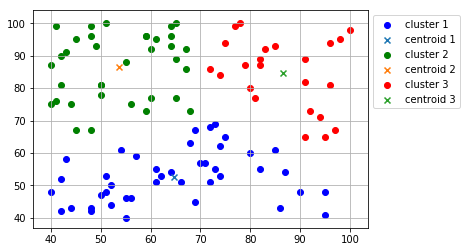

In [14]:
clusters, centers = k_means(samples, k=3)
report_result(clusters, centers)

<hr>

# مراجع
- http://webpage.pace.edu/aa10212w/course/CS855/hw5-k-means-clustering.html]()

<hr>

For revealjs rigth-to-left text

In [15]:
%%HTML
<style>div.text_cell_render {text-align: right;}</style>